# Offline hand-eye callibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys

from apriltag import apriltag

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration

In [2]:
data_root = '../../../../../data/cobot/calibration/calibdata_2025_08_05-13_52_20'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

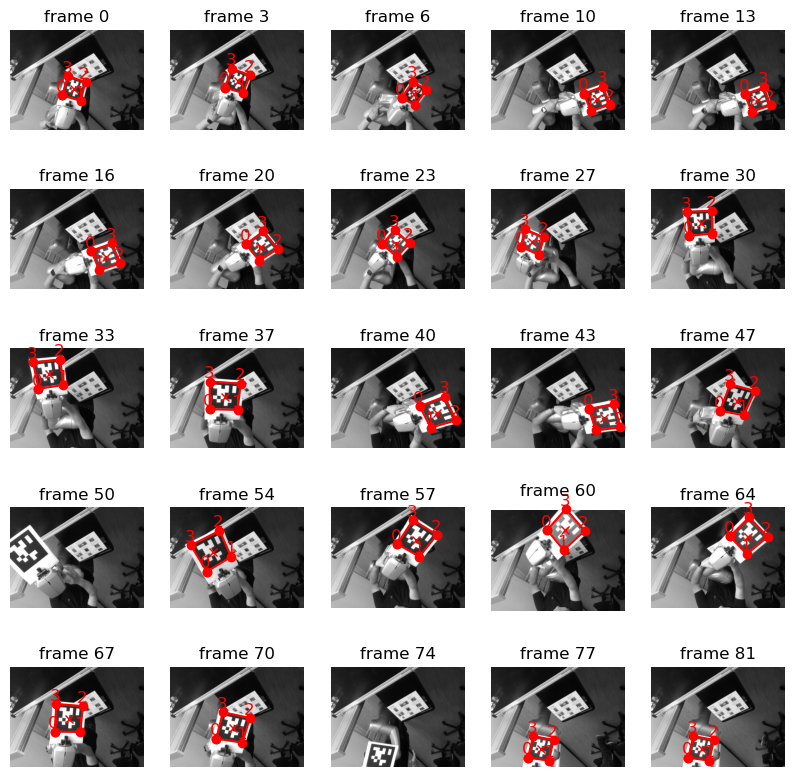

In [3]:
apriltag_family = 'tag36h11'
detector = apriltag(apriltag_family)

plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, 81, 25, dtype=int)):    
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(40, data_root, detector)
frame

{'image_timestamp': (1754395176, 851774902),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', -0.6173562621999145),
                            ('y', 0.9379498961290829),
                            ('z', -0.4402875804528676)])),
              ('rotation',
               OrderedDict([('x', 0.3032588544076704),
                            ('y', 0.6492529757489174),
                            ('z', -0.4753842501343331),
                            ('w', 0.5104061671147213)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754395176),
                                          ('nanosec', 384733643)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
           

In [5]:
#frame_samples = [0, 3, 13, 16, 27, 30, 33, 37, 40, 47, 54, 64, 70, 77]
frame_samples = [0, 2, 6, 10, 19, 22, 26, 29, 31, 33, 35, 36, 37, 39, 41, 47, 53, 64, 72, 78]

In [6]:
tagsize = 0.14  # Size of the tag in meters
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[ 0.65975334 -0.37559205  0.65088873]
 [-0.14165401  0.78845594  0.59855774]
 [-0.73801062 -0.48710147  0.46698232]]
Quaternion (wxyz):
[ 0.85369661 -0.31792887  0.40673096  0.06850737]
Translation Vector:
[[-0.11209736]
 [ 0.52936886]
 [ 0.97027066]]


Reference: 

```bash
Hand-Eye Calibration Results:
Rotation Matrix:
[[ 0.99084876 -0.06789273 -0.11665893]
 [ 0.05717175  0.99403161 -0.09291156]
 [ 0.12227068  0.08539171  0.98881653]]
Quaternion (wxyz):
[ 0.99670669  0.04472311 -0.05992977  0.03136943]
Translation Vector:
[[-0.25556454]
 [ 0.50022198]
 [ 1.02821659]]
```

In [7]:
calibration_file = '../../../handeye_calibration.json'
save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                 frame_samples, data_root)

loaded_calibration = load_calibration(calibration_file)
print("Loaded Calibration:")
print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.11209736113115804], [0.5293688565179477], [0.9702706648952488]], 'rotation_q_wxyz': [0.8536966082024183, -0.31792887498817063, 0.4067309571507494, 0.06850737250601674], 'selected_samples': [0, 2, 6, 10, 19, 22, 26, 29, 31, 33, 35, 36, 37, 39, 41, 47, 53, 64, 72, 78], 'data_file_path': '../../../../../data/cobot/calibration/calibdata_2025_08_05-13_52_20'}


## Stability testing

In [8]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [-0.66880355  0.85560995  0.14411391] , translation:  [-0.11209736  0.52936886  0.97027066]
permutation=01 : rotation:  [-0.66880355  0.85560995  0.14411391] , translation:  [-0.15844252  0.51203888  0.9697339 ]
permutation=02 : rotation:  [-0.66880355  0.85560995  0.14411391] , translation:  [-0.20992449  0.48644273  0.96295641]
permutation=03 : rotation:  [-0.66880355  0.85560995  0.14411391] , translation:  [-0.22688926  0.46244804  1.00514225]
permutation=04 : rotation:  [-0.66880355  0.85560995  0.14411391] , translation:  [-0.28730925  0.45446072  0.95786987]


In [9]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())


len=05 : rotation:  [-0.01003794  1.05477413  0.56359705] , translation:  [-0.41903549  0.39996541  0.99047223]
len=06 : rotation:  [-0.21849887  1.2650587   0.37283052] , translation:  [-0.3746976   0.31520875  1.07141306]
len=07 : rotation:  [-0.20527767  1.22479477  0.52874411] , translation:  [-0.44560293  0.26878788  1.11658429]
len=08 : rotation:  [-0.16624575  0.97287014  0.56543895] , translation:  [-0.3297814   0.4211954   1.00753161]
len=09 : rotation:  [-0.15218855  1.26966537  0.52504175] , translation:  [-0.40185874  0.25619383  1.07646915]
len=10 : rotation:  [-0.19884174  1.30855658  0.49762841] , translation:  [-0.38138989  0.17421539  1.13527572]
len=11 : rotation:  [-0.19526455  1.43037323  0.48656611] , translation:  [-0.42113972  0.11238805  1.18114083]
len=12 : rotation:  [-0.19104709  1.41787981  0.46522665] , translation:  [-0.43227315  0.13048478  1.19363269]
len=13 : rotation:  [-0.57026124  1.1819001   0.48710388] , translation:  [-0.34209361  0.2241575   1.12

## Reprojection test

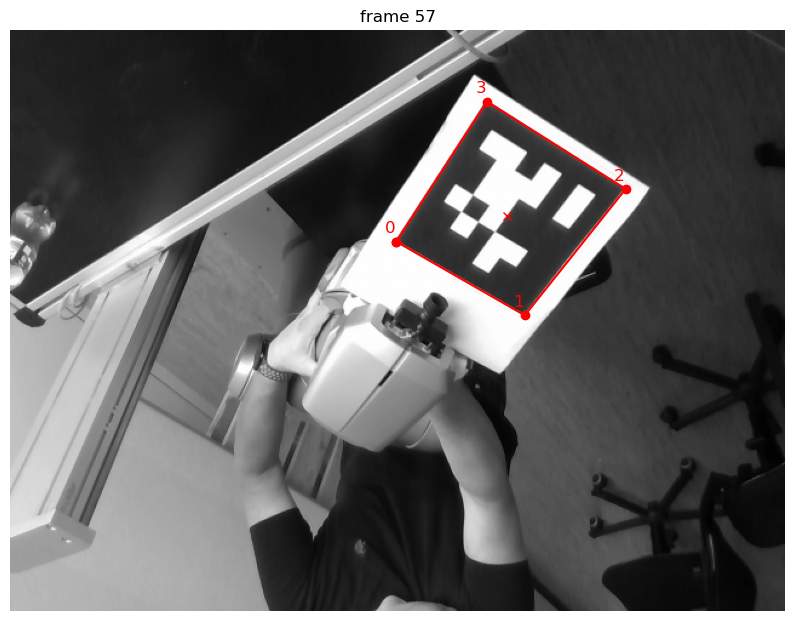

In [10]:
frame_count = 57
frame, gray, detections = load_and_detect(frame_count, data_root, detector)
plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count);

In [11]:
frame

{'image_timestamp': (1754395192, 329364014),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', -0.056937131045650013),
                            ('y', 1.1731365050838733),
                            ('z', -0.0711498734468512)])),
              ('rotation',
               OrderedDict([('x', 0.4387951132822603),
                            ('y', 0.6766051418079085),
                            ('z', -0.5743504248629943),
                            ('w', 0.14066243314547858)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754395191),
                                          ('nanosec', 929082764)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
        